In [1]:
from queue import PriorityQueue
from typing import List, Tuple, TypeVar, Dict
from tilsdk.localization import *
import heapq

T = TypeVar('T')

class NoPathFoundException(Exception):
    pass


class PriorityQueue:
    def __init__(self):
        self.elements: List[Tuple[float, T]] = []

    def is_empty(self) -> bool:
        return not self.elements

    def put(self, item: T, priority: float):
        heapq.heappush(self.elements, (priority, item))

    def get(self) -> T:
        return heapq.heappop(self.elements)[1]


class MyPlanner:
    def __init__(self, map_:SignedDistanceGrid=None, sdf_weight:float=0.0):
        '''
        Parameters
        ----------
        map : SignedDistanceGrid
            Distance grid map
        sdf_weight: float
            Relative weight of distance in cost function.
        '''
        self.map = map_
        self.sdf_weight = sdf_weight

    def update_map(self, map:SignedDistanceGrid):
        '''Update planner with new map.'''
        self.map = map

    def heuristic(self, a:GridLocation, b:GridLocation) -> float:
        '''Planning heuristic function.
        Not used here -Qr
        
        Parameters
        ----------
        a: GridLocation
            Starting location.
        b: GridLocation
            Goal location.
        '''
        return euclidean_distance(a, b)

    def plan(self, start:RealLocation, goal:RealLocation) -> List[RealLocation]:
        '''Plan in real coordinates.
        
        Raises NoPathFileException path is not found.

        Parameters
        ----------
        start: RealLocation
            Starting location.
        goal: RealLocation
            Goal location.
        
        Returns
        -------
        path
            List of RealLocation from start to goal.
        '''

        path = self.plan_grid(self.map.real_to_grid(start), self.map.real_to_grid(goal))
        path = [self.map.grid_to_real(wp) for wp in path]
        
        pathmap = map_.grid.copy()
        pathmap = pathmap > 0
        pathmap = pathmap.astype("int32")
        gridpath = [map_.real_to_grid(x) for x in path]
        gridpathx = [x[0] for x in gridpath]
        gridpathy = [x[1] for x in gridpath]
        for loc in gridpath:
            pathmap[loc] = 2
        plt.imshow(pathmap)
        plt.scatter(gridpathx,gridpathy,c='r')
        plt.title("grid and path")
        plt.show()
        
        return path

    def plan_grid(self, start:GridLocation, goal:GridLocation) -> List[GridLocation]:
        '''Plan in grid coordinates.
        
        Raises NoPathFileException path is not found.

        Parameters
        ----------
        start: GridLocation
            Starting location.
        goal: GridLocation
            Goal location.
        
        Returns
        -------
        path
            List of GridLocation from start to goal.
        '''
        
        start = start[1],start[0]
        goal = goal[1],goal[0] #Use i=x,j=y convention for convenience
        
        #Dijkstra's Algorithm/bfs
        if not self.map:
            raise RuntimeError('Planner map is not initialized.')

        pq = PriorityQueue() # ((Prev_waypoint,cur_moving_direction), priority)
        #Directions = 0 U, 1 R, 2 D, 3 L; -1 start (no irection); 4-7 diagonals
        dx = [0,1,0,-1,1,1,-1,-1]
        dy = [1,0,-1,0,1,-1,1,-1]
        dist = [10,10,10,10,14.142,14.142,14.142,14.142]
        
        pq.put(start, 0)
        
        prev_waypoint: Dict[tuple(int,int), tuple(int,int) ] = {}
        cost_so_far: Dict[tuple(int,int), float] = {}
        prev_waypoint[tuple(start)] = None
        cost_so_far[tuple(start)] = 0
        vis = np.zeros(map_.grid.shape)
        done = False
        passable = self.map.grid>0
        #plt.imshow(passable)
        
        
        print("Start passable")
        print("original goal",goal)
        #The goal must be passable. If not, we find the nearest passabel point
        if not passable[goal]:
            best = (1e18,(-1,-1))
            for i in range(map_.height): #y
                for j in range(map_.width): #x
                    if map_.grid[(i,j)]>0:
                        best = min(best,(self.heuristic(GridLocation(i,j),goal),(i,j)))
            goal = best[1]
        print("goal",goal)
        
        while not done and not pq.is_empty():
            location = pq.get()
            if vis[location]:
                continue
            vis [location] = 1
            
            cost = cost_so_far[location]
            prev = prev_waypoint[location]
        
            for i in range(8):
                cur = (location[0]+dx[i],location[1]+dy[i])
                if (0<=cur[0]<self.map.height) and (0<=cur[1]<self.map.width) and (passable[cur]):
                    if (cur not in cost_so_far) or (cost + dist[i] < cost_so_far[cur]):
                        cost_so_far[cur] = cost + dist[i]
                        prev_waypoint[cur] = location
                        pq.put(cur, cost+dist[i])
                        done += (cur==goal)
        plt.imshow(vis)
        plt.title("Visited tiles in bfs")
        plt.show()
        
        if goal not in prev_waypoint:
            raise NoPathFoundException        
            
        return self.reconstruct_path(prev_waypoint, start, goal)

    def reconstruct_path(self,
                         came_from:Dict[GridLocation, GridLocation],
                         start:GridLocation, goal:GridLocation) -> List[GridLocation]:
        '''Traces traversed locations to reconstruct path.
        
        Parameters
        ----------
        came_from: dict
            Dictionary mapping location to location the planner came from.
        start: GridLocation
            Start location for path.
        goal: GridLocation
            Goal location for path.

        Returns
        -------
        path
            List of GridLocation from start to goal.
        '''
        current: GridLocation = goal
        path: List[GridLocation] = [goal]
        
        
        while current != start:
            path.append(current)
            current = came_from[current]
            
        # path.append(start)
        path.reverse()
        path = path[:1] + path[1:-1:20]+ path[-1:] #Take the 1st, last, and every 20th waypoint in the middle
        path = [(x[1],x[0]) for x in path]
        #print(path)
        
        return path

In [2]:
import logging
from typing import List

from tilsdk import *                                            # import the SDK
from tilsdk.utilities import PIDController, SimpleMovingAverage # import optional useful things
from tilsdk.mock_robomaster.robot import Robot                  # Use this for the simulator
# from robomaster.robot import Robot                             # Use this for real robot

# Import your code
from stubs.cv_service import CVService, MockCVService
from stubs.nlp_service import NLPService, MockNLPService
from stubs.planner import Planner

c:\users\qirui\appdata\local\programs\python\python38\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
# Setup logging in a nice readable format
logging.basicConfig(level=logging.INFO,
                format='[%(levelname)5s][%(asctime)s][%(name)s]: %(message)s',
                datefmt='%H:%M:%S')

# Define config variables in an easily accessible location
# You may consider using a config file
REACHED_THRESHOLD_M = 0.3   # TODO: Participant may tune.
ANGLE_THRESHOLD_DEG = 20.0  # TODO: Participant may tune.
ROBOT_RADIUS_M = 0.17       # TODO: Participant may tune.
NLP_MODEL_DIR = '../model.onnx'          # TODO: Participant to fill in.
NLP_PREPROCESSOR_DIR = '../finals_audio_model/'          # TODO: Participant to fill in.
CV_MODEL_DIR = ''           # TODO: Participant to fill in.

# Convenience function to update locations of interest.
def update_locations(old:List[RealLocation], new:List[RealLocation]) -> None:
    '''Update locations with no duplicates.'''
    if new:
        for loc in new:
            if loc not in old:
                logging.getLogger('update_locations').info('New location of interest: {}'.format(loc))
                old.append(loc)

In [4]:
# Initialize services
# cv_service = CVService(model_dir=CV_MODEL_DIR)



cv_service = MockCVService(model_dir=CV_MODEL_DIR)

#nlp_service = NLPService(model_dir=NLP_MODEL_DIR, preprocessor_dir=NLP_PREPROCESSOR_DIR)
nlp_service = MockNLPService(model_dir=NLP_MODEL_DIR)

loc_service = LocalizationService(host='localhost', port=5566)

#rep_service = ReportingService(host='localhost', port=5501)
# Start the run
#rep_service.start_run()

robot = Robot()
robot.initialize(conn_type="sta")
robot.camera.start_video_stream(display=False, resolution='720p')

In [5]:
# Initialize planner
map_:SignedDistanceGrid = loc_service.get_map()
map_ = map_.dilated(1.5*ROBOT_RADIUS_M/map_.scale)
planner = MyPlanner(map_, sdf_weight=0.5)

# Initialize variables
seen_clues = set()
curr_loi:RealLocation = None
path:List[RealLocation] = []
lois:List[RealLocation] = []
curr_wp:RealLocation = None

# Initialize tracker
# TODO: Participant to tune PID controller values.
tracker = PIDController(Kp=(1.0, 45.0), Kd=(0.0, 0.0), Ki=(0.0, 0.0)) #first: displacement, second: angle

# Initialize pose filter
pose_filter = SimpleMovingAverage(n=5)

# Define filter function to exclude clues seen before   
new_clues = lambda c: c.clue_id not in seen_clues

In [6]:
#Tune here
tracker = PIDController(Kp=(0.5, 1.0), Kd=(0.0, 0.0), Ki=(0.0, 0.0)) #first: displacement, second: angle

[ INFO][12:30:55][update_locations]: New location of interest: RealLocation(x=4.0, y=3.0)
[ INFO][12:30:55][Main]: Current LOI set to: RealLocation(x=4.0, y=3.0)
[ INFO][12:30:55][Main]: Planning path to: RealLocation(x=4.0, y=3.0)


Start passable
original goal (300, 400)
goal (300, 400)


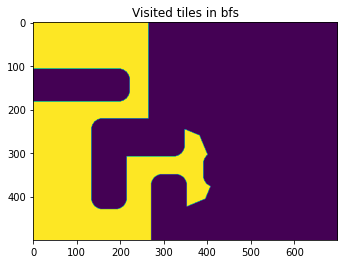

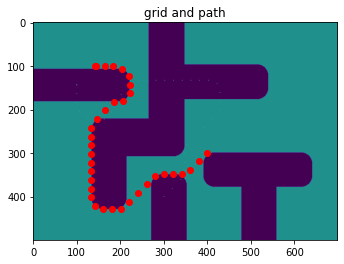

[ INFO][12:30:58][Main]: Path planned.
[ INFO][12:31:02][update_locations]: New location of interest: RealLocation(x=4.0, y=3.0)
[ INFO][12:31:02][Navigation]: New waypoint: RealLocation(x=1.43, y=1.0)
[ INFO][12:31:02][Navigation]: Pose: RealPose(x=1.4216513344339587, y=1.0, z=0.0)
[ INFO][12:31:02][Navigation]: Reached wp: RealLocation(x=1.43, y=1.0)
[ INFO][12:31:06][Navigation]: New waypoint: RealLocation(x=1.44, y=1.0)
[ INFO][12:31:06][Navigation]: Pose: RealPose(x=1.4216513344339587, y=1.0, z=0.0)
[ INFO][12:31:06][Navigation]: Reached wp: RealLocation(x=1.44, y=1.0)
[ INFO][12:31:10][Navigation]: New waypoint: RealLocation(x=1.6400000000000001, y=1.0)
[ INFO][12:31:10][Navigation]: Pose: RealPose(x=1.4216513344339587, y=1.0, z=0.0)
[ INFO][12:31:10][Navigation]: Reached wp: RealLocation(x=1.6400000000000001, y=1.0)
[ERROR][12:31:16][root]: Internal Python error in the inspect module.
Below is the traceback from this internal error.

[ INFO][12:31:16][root]: 
Unfortunately, your

Traceback (most recent call last):
  File "c:\users\qirui\appdata\local\programs\python\python38\lib\site-packages\urllib3\util\connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\qirui\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-5b8f9ed04be8>", line 6, in <module>
    img = robot.camera.read_cv2_image(strategy='newest')
  File "c:\users\qirui\appdata\local\programs\python\python38\lib\site-packages\tilsdk\mock_robomaster\camera.py", line 32, in read_cv2_image
    response = self.manager.request(method='GET',
  File "c:\users\qirui\appdata\local\programs\python\python38\lib\site-packages\ur

TypeError: object of type 'NoneType' has no len()

In [7]:
# Main loop
while True:
    # Get new data
    pose, clues = loc_service.get_pose()
    pose = pose_filter.update(pose)
    img = robot.camera.read_cv2_image(strategy='newest')
    if not pose:
        # no new data, continue to next iteration.
        continue

    # Filter out clues that were seen before
    clues = filter(new_clues, clues)

    # Process clues using NLP and determine any new locations of interest
    if clues:
        new_lois = nlp_service.locations_from_clues(clues) #new locations of interest
        update_locations(lois, new_lois)
        seen_clues.update([c.clue_id for c in clues])

    """    # Process image and detect targets
    targets = cv_service.targets_from_image(img)

    # Submit targets
    if targets:
        logging.getLogger('Main').info('{} targets detected.'.format(len(targets)))
        #logging.getLogger('Reporting').info(rep_service.report(pose, img, targets))
    """
    if not curr_loi:
        if len(lois) == 0:
            logging.getLogger('Main').info('No more locations of interest.')
            # TODO: You ran out of LOIs. You could perform and random search for new
            # clues or targets
            break
        else:
            # Get new LOI
            lois.sort(key=lambda l: euclidean_distance(l, pose), reverse=True)
            curr_loi = lois.pop()
            logging.getLogger('Main').info('Current LOI set to: {}'.format(curr_loi))

            # Plan a path to the new LOI
            logging.getLogger('Main').info('Planning path to: {}'.format(curr_loi))
            
            path = planner.plan(pose[:2], curr_loi)
            #path = [curr_loi,curr_loi]
            path.reverse() # reverse so closest wp is last so that pop() is cheap , waypoint
            curr_wp = None
            logging.getLogger('Main').info('Path planned.')
    else:
        # There is a current LOI objective.
        # Continue with navigation along current path.
        if path:
            # Get next waypoint
            if not curr_wp:
                curr_wp = path.pop()
                logging.getLogger('Navigation').info('New waypoint: {}'.format(curr_wp))

            #logging.getLogger('Navigation').info('Calculating angle')
            # Calculate distance and heading to waypoint
            dist_to_wp = euclidean_distance(pose, curr_wp)
            ang_to_wp = np.degrees(np.arctan2(curr_wp[1]-pose[1], curr_wp[0]-pose[0]))
            ang_diff = -(ang_to_wp - pose[2]) # body frame

            # ensure ang_diff is in [-180, 180]
            if ang_diff < -180:
                ang_diff += 360

            if ang_diff > 180:
                ang_diff -= 360

            #logging.getLogger('Navigation').info('ang_to_wp: {}, hdg: {}, ang_diff: {}'.format(ang_to_wp, pose[2], ang_diff))
            logging.getLogger('Navigation').info('Pose: {}'.format(pose))
            
            # Consider waypoint reached if within a threshold distance
            if dist_to_wp < REACHED_THRESHOLD_M:
                logging.getLogger('Navigation').info('Reached wp: {}'.format(curr_wp))
                tracker.reset()
                curr_wp = None
                continue

            # Determine velocity commands given distance and heading to waypoint
            vel_cmd = tracker.update((dist_to_wp, ang_diff))

            logging.getLogger('Navigation').info('dist: {} ang:{} vel:{}'.format(dist_to_wp,ang_diff,vel_cmd))
            
            # reduce x velocity
            vel_cmd[0] *= np.cos(np.radians(ang_diff))

            # If robot is facing the wrong direction, turn to face waypoint first before
            # moving forward.
            if abs(ang_diff) > ANGLE_THRESHOLD_DEG:
                vel_cmd[0] = 0.0

            # Send command to robot
            robot.chassis.drive_speed(x=vel_cmd[0], z=vel_cmd[1])

        else:
            logging.getLogger('Navigation').info('End of path.')
            curr_loi = None

            # TODO: Perform search behaviour? Participant to complete.

            continue

robot.chassis.drive_speed(x=0.0, y=0.0, z=0.0)  # set stop for safety
logging.getLogger('Main').info('Mission Terminated.')

# Below: Random working

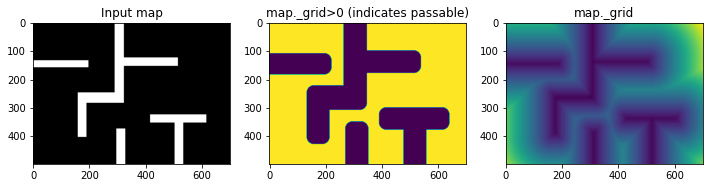

In [9]:
fig, ax = plt.subplots(1,3,figsize=(12,30))
ax[0].imshow(plt.imread("data/maps/map_complex_1cm.png"))
ax[0].title.set_text("Input map")
ax[1].imshow(map_.grid>0)
ax[1].title.set_text("map._grid>0 (indicates passable)")
ax[2].imshow(map_.grid)
ax[2].title.set_text("map._grid")

In [71]:
curr_loi

RealLocation(x=4.0, y=3.0)

## Test planner manually

In [293]:
myplanner = MyPlanner(map_, sdf_weight=0.5)
curr_loi = RealLocation(x=4.0, y=3.0)
pose = RealPose(x=1.0, y=1.0, z=0.0)

original goal (300, 400)
goal (300, 400)
1.5269954204559326


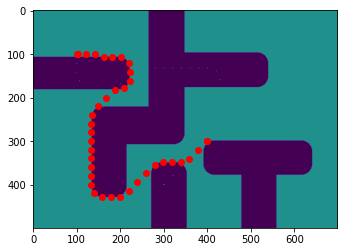

In [294]:
import time
start = time.time()
path = None #Needed or path will be taken as a local variable in try
try:
    path = myplanner.plan(pose[:2], curr_loi)
except(err):
    print("Error",err)
end = time.time()
print(end - start)

In [287]:
path

[RealLocation(x=1.01, y=1.0),
 RealLocation(x=1.02, y=1.0),
 RealLocation(x=1.22, y=1.0),
 RealLocation(x=1.42, y=1.0),
 RealLocation(x=1.62, y=1.06),
 RealLocation(x=1.82, y=1.06),
 RealLocation(x=2.02, y=1.06),
 RealLocation(x=2.2, y=1.21),
 RealLocation(x=2.22, y=1.41),
 RealLocation(x=2.22, y=1.61),
 RealLocation(x=2.08, y=1.79),
 RealLocation(x=1.8800000000000001, y=1.82),
 RealLocation(x=1.68, y=2.0),
 RealLocation(x=1.48, y=2.2),
 RealLocation(x=1.34, y=2.4),
 RealLocation(x=1.33, y=2.6),
 RealLocation(x=1.33, y=2.8000000000000003),
 RealLocation(x=1.33, y=3.0),
 RealLocation(x=1.33, y=3.2),
 RealLocation(x=1.33, y=3.4),
 RealLocation(x=1.33, y=3.6),
 RealLocation(x=1.33, y=3.8000000000000003),
 RealLocation(x=1.33, y=4.0),
 RealLocation(x=1.3900000000000001, y=4.2),
 RealLocation(x=1.59, y=4.29),
 RealLocation(x=1.79, y=4.29),
 RealLocation(x=1.99, y=4.29),
 RealLocation(x=2.19, y=4.14),
 RealLocation(x=2.39, y=3.94),
 RealLocation(x=2.59, y=3.74),
 RealLocation(x=2.79, y=3.54)

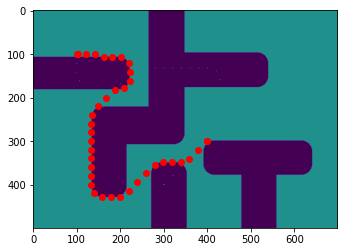

In [288]:
pathmap = map_.grid.copy()
pathmap = pathmap > 0
pathmap = pathmap.astype("int32")
gridpath = [map_.real_to_grid(x) for x in path]
gridpathx = [x[0] for x in gridpath]
gridpathy = [x[1] for x in gridpath]
for loc in gridpath:
    pathmap[loc] = 2
plt.imshow(pathmap)
plt.scatter(gridpathx,gridpathy,c='r')